# People Analytics - Project filling Demo

This notebook walks through quick examples of how to **recommend people to fill projects** using different approaches:
- Right mix of skills
- Worked on similar projects
- Influential people
- Form Communities of Practice
- People with Similar Experience

Some other examples using Neo4j Browser and *:play field/pocs/kghrdemo.html* 


## Notebook Setup

Notebook was created running with
- Neo4j Enterprise 4.4.12
- Graph Data Science Library 2.1.12

In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import configparser
import os
import matplotlib.pyplot as plt
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 12)

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>
DATABASE=<database>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
DATABASE = 'neo4j'
```

In [2]:
NEO4J_PROPERTIES_FILE = './neo4jconnection.ini'

In [3]:
## Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
DATABASE = 'neo4j'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    DATABASE = config['NEO4J']['DATABASE']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Using custom database properties


# People Analytics - Project filling Demo

## Dataset: Personel/Projects/Skills

The examples in this notebook primarily focus on the left hand side of the graph - Personnel, Projects and Skills, there are 3 patterns to relate Personnel to skills

- Declared skills
  - (:Personnel)-[:DECLARED_SKILL]->(:Skill)
- Inferred skills
  - by projects they worked on (have had some exposure to skill)
    - (per:Personnel)-[:HAS_ACTIVE_STATUS]->(ps)-[:INVOLVED_IN]->(p:Project)-[:REQUIRED_SKILL]->(sk:Skill)
  - by skill hierarchy (knowing some skill gives related knowledge of broader skills or sibling skills)
    - (:Skill)-[:SUB_CLASS_OF]->(:Skill)

![graphdatamodel.png](img/graphdatamodel.png)

```
//visualize schema in Neo4j Browser
CALL db.schema.visualization();
```

## Graph Data Profiling
Before diving right into into analysis, it is helpful to inspect some high level statistics of graph to get a better sense of size and connectivity.

In [4]:
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=False)
gds.set_database(DATABASE)

#### Aggregate Counts
Let's start with high node and relationships counts. These functions assume [APOC](https://neo4j.com/developer/neo4j-apoc/) is installed on your Neo4j DB.

In [5]:
# total node counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['Position','Project','Skill','Personnel']
    RETURN label, nodeCount
''')

,label,nodeCount
0,Position,40001
1,Personnel,30001
2,Project,999
3,Skill,12576


In [6]:
# total relationship counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['REQUIRED_SKILL','DECLARED_SKILL']
    RETURN type, relationshipCount
''')

,type,relationshipCount
0,DECLARED_SKILL,63
1,REQUIRED_SKILL,2728


Lets have a look at the frequency of project required skills

In [7]:
skills_df = gds.run_cypher('''
MATCH (p:Project)-[:REQUIRED_SKILL]->(sk:Skill)
RETURN sk.name AS skill, count(p) AS freq LIMIT 30
''')

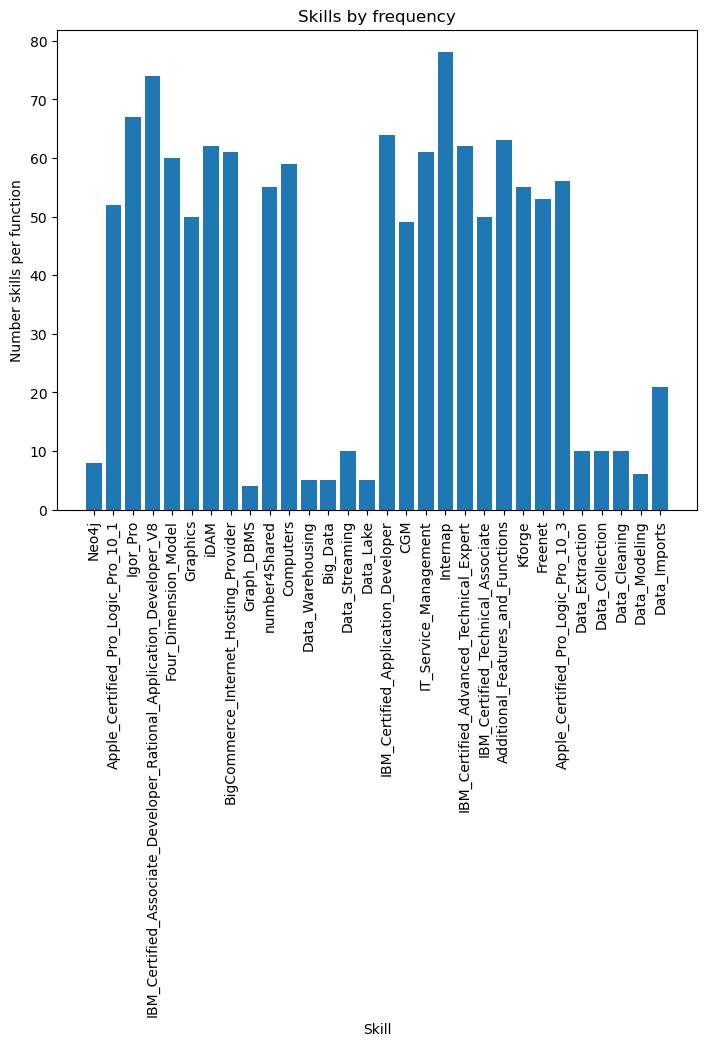

In [8]:
fig = plt.figure()

axs = fig.add_axes([0,0,1,1])
axs.bar(skills_df.skill,skills_df.freq)
axs.set_title('Skills by frequency')
axs.set_xlabel('Skill')
axs.set_ylabel('Number skills per function')
plt.xticks(rotation=90)
plt.show()

# plt.show()

## Project Filling


#### What skills are required for a this project?

In [9]:
PROJECT='Australian brush turkey'

In [10]:
gds.run_cypher('''
    MATCH (p:Project)-[:REQUIRED_SKILL]->(skill) 
        WHERE p.name=$project_name
    RETURN skill.label AS Skill
''', params={'project_name': PROJECT})

,Skill
0,Freenet
1,Apple Certified Pro - Logic Pro 10.3
2,Data Extraction
3,Data Collection
4,Data Streaming
5,Data Cleaning
6,Data Modeling
7,Data Imports


#### What skills does a person have, both declared skills and inferred skills

In [11]:
NAME = "Sidney Goaks" 

In [12]:
gds.run_cypher('''
    MATCH personSubGraph = (per:Personnel { name : $name })-[:HAS_ACTIVE_STATUS]->(ps)-[:INVOLVED_IN]->(p:Project)-[:REQUIRED_SKILL]->(sk:Skill),
       (per)-[DECLARED_SKILL]->(sk2:Skill)
    WITH collect(DISTINCT sk2.name) as declaredSkills, collect(DISTINCT sk.name) AS inferredSkills
    WITH declaredSkills, inferredSkills, inferredSkills+declaredSkills as allSkills
    UNWIND allSkills as skill
    WITH skill, 
        CASE
           WHEN skill in inferredSkills AND skill in declaredSkills THEN 'declared + inferred'
           WHEN skill in declaredSkills THEN 'declared'
           ELSE 'inferred'
       END AS skillType
    RETURN DISTINCT skill, skillType ORDER BY skillType ASC
''', params={'name': NAME})

,skill,skillType
0,Spark,declared
1,Python,declared
2,Neo4j,declared
3,Infrastructure_Platforms,declared + inferred
4,Data_Cleaning,declared + inferred
5,Data_Extraction,inferred
6,Data_Collection,inferred
7,Data_Streaming,inferred
8,Data_Modeling,inferred
9,Data_Imports,inferred


#### Skill Hierarchy

In [13]:
NAME = "Neo4j"

In [14]:
gds.run_cypher('''
    MATCH skillshierarchy = (:Skill {name:$name})-[:SUB_CLASS_OF*]->()
    UNWIND nodes(skillshierarchy) as skill
    RETURN DISTINCT skill.name AS skill
''', params={'name': NAME})

,skill
0,Neo4j
1,Graph_DBMS
2,DBMS


#### Recommending people for the project based on no. co-occuring skills, leveraging skill hierarchy

Using Cypher and calculate overlap between required skills of the project and declared and inferred skills with scoring based on direct/indirect skills

In [15]:
gds.run_cypher('''
    MATCH (p:Project)-[:REQUIRED_SKILL]->(sk) 
        WHERE p.name=$project_name
    WITH p, collect(sk) AS requskills, COLLECT(DISTINCT sk.name) AS projectSkills  limit 1
    CALL {
        WITH p, requskills
        MATCH path = (pers:Personnel)-[:DECLARED_SKILL]->(decSk)-[:SUB_CLASS_OF*0..2]->(:Skill)<-[:SUB_CLASS_OF*0..2]-(ds) where ds in requskills
        RETURN pers.name AS personName, decSk.name AS matchedSkill, ds.name AS projectSkill, 'declared skill' AS matchType, 1.0/length(path) AS score
    UNION
        WITH p, requskills
        MATCH path = (pers:Personnel)-[:HAS_ACTIVE_STATUS]->(po:PositionStatus)-[:INVOLVED_IN]-(pr:Project)-[:REQUIRED_SKILL]-(reqSk)-[:SUB_CLASS_OF*0..2]->(:Skill)<-[:SUB_CLASS_OF*0..2]-(ds) where ds in requskills
        RETURN pers.name AS personName, reqSk.name AS matchedSkill, ds.name AS projectSkill, 'inferred skill' AS matchType, 1.0/(length(path)-2) AS score
    }
    RETURN DISTINCT personName, SUM(score) AS finalScore, apoc.map.fromLists(COLLECT(matchedSkill),COLLECT(matchType)) AS matchedSkills
    ORDER BY finalScore DESC LIMIT 10
''', params={'project_name': PROJECT})    

,personName,finalScore,matchedSkills
0,Nariko Fretson,17.000000,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Imports': 'inferred skill', 'APPC': 'inferred skill'}"
1,Clayson Agget,16.666667,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Imports': 'inferred skill'}"
2,Preston Kosel,13.666667,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Apple_Certified_Pro_Logic_Pro_10_3': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Freenet': 'inferred skill', 'Data_Imports': 'inferred skill'}"
3,Fae Challiner,13.666667,"{'Data_Extraction': 'inferred skill', 'Apple_Certified_Pro_Logic_Pro_10_1': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Data_Streaming': 'declared skill', 'Data_Collection': 'inferred skill', 'Data_Imports': 'inferred skill'}"
4,Lira Alliot,12.000000,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Apple_Certified_Pro_Logic_Pro_10_3': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Freenet': 'inferred skill', 'Data_Imports': 'inferred skill'}"
5,Libby Campbell-Dunlop,12.000000,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Apple_Certified_Pro_Logic_Pro_10_3': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Freenet': 'inferred skill', 'Data_Imports': 'inferred skill'}"
6,Mabel Palphramand,12.000000,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Apple_Certified_Pro_Logic_Pro_10_3': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Freenet': 'inferred skill', 'Data_Imports': 'inferred skill'}"
7,Rainer Rosini,12.000000,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Apple_Certified_Pro_Logic_Pro_10_3': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Freenet': 'inferred skill', 'Data_Imports': 'inferred skill'}"
8,Antonina Whisker,12.000000,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Apple_Certified_Pro_Logic_Pro_10_3': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Freenet': 'inferred skill', 'Data_Imports': 'inferred skill'}"
9,Sidney Goaks,11.666667,"{'Data_Extraction': 'inferred skill', 'Data_Modeling': 'inferred skill', 'Data_Cleaning': 'inferred skill', 'Data_Collection': 'inferred skill', 'Data_Streaming': 'inferred skill', 'Data_Imports': 'inferred skill'}"


## Project Similarity

We can look at the which skills are declared as required for a project, and using similarity algorithm find other projects that have required similar sets of skills, we can then look at the teams that worked on those projects

- project the project/skill subgraph
- run node similarity
- write similarity results back to the graph ()-[:SIMILAR_PROJECT {similarity_score}]->()

In [45]:
## Gets project similarity
projectsG, result = gds.graph.project( 
    'projectsGraph', 
    ['Skill','Project'], 
    ['REQUIRED_SKILL']
);

In [46]:
project_similarity = gds.nodeSimilarity.stream(projectsG)

In [47]:
project_similarity.head(10)

,node1,node2,similarity
0,739635,739668,0.333333
1,739635,739636,0.333333
2,739635,739664,0.250000
3,739635,739637,0.250000
4,739635,739667,0.200000
5,739635,739666,0.200000
6,739635,739665,0.200000
7,739636,745410,0.666667
8,739636,743495,0.500000
9,739636,743206,0.500000


In [48]:
res = gds.nodeSimilarity.write(projectsG, writeRelationshipType="SIMILAR_PROJECT", writeProperty="similarity_score", similarityCutoff=0.4)
res.relationshipsWritten, res.computeMillis, res.writeMillis

(5803, 218, 122)

In [20]:
gds.run_cypher('''
    MATCH (p:Project)-[r:SIMILAR_PROJECT]->(sp) 
        WHERE p.name=$project_name
    RETURN DISTINCT sp.name AS project, r.similarity_score AS score 
        ORDER BY score DESC
        LIMIT 10
''', params={'project_name': PROJECT}) 

,project,score
0,Kori bustard,0.777778
1,city_of_seattle_data_plattform,0.666667
2,Rock dove,0.545455
3,Cape fox,0.545455
4,"Deer, swamp",0.400000
5,"Owl, burrowing",0.400000
6,"Woodpecker, red-headed",0.400000


In [21]:
res=projectsG.drop()

### Who has worked on top 10 most similar projects

In [22]:
gds.run_cypher('''
    MATCH (p:Project)-[r:SIMILAR_PROJECT]->(similarp) 
        WHERE p.name=$project_name
    WITH similarp, r.similarity_score AS score 
        ORDER BY score DESC
        LIMIT 10
    MATCH (pos:Personnel)-[:HAS_ACTIVE_STATUS]->(ps)-[:INVOLVED_IN]->(similarp)
    RETURN pos.name, COUNT(similarp) AS no_similar ORDER BY no_similar DESC
''', params={'project_name': PROJECT}) 

,pos.name,no_similar
0,Maximo Winspear,1
1,Crystie Glaves,1
2,Lizzy Humbell,1
3,Tadio Udall,1
4,Nerta Toward,1
...,...,...
37,Alexa Bartalin,1
38,Brandtr Brownscombe,1
39,Anatol Fredy,1
40,Viola Dunniom,1


## Influential People

Centrality algorithms can help see how influential people are, this might help us by assigning someone with good connectivity to the rest of the organization who might be able to remove roadblocks, or alternatively we could look for lower centrality if we want to help them connect to broader teams

- Using Cypher we can see who has worked together in the past and on how many projects
- We can reshape the subgraph using Cypher creating a summary relationship between people using the no. projects as a weighting
- Run centrality algorithm and write score back to the Personnel nodes
- rank the candidates working on similar projects based on their centrality score

In [23]:
gds.run_cypher('''
MATCH (person1:Personnel)-[:HAS_HISTORY]->()-[:INVOLVED_IN]->(project)<-[:INVOLVED_IN]-()<-[:HAS_HISTORY]-(person2:Personnel)
    WHERE ID(person1) <> ID(person2)
RETURN person1.name, person2.name, count(project) AS weight ORDER BY weight DESC
''')

,person1.name,person2.name,weight
0,Leonanie Boshere,Bertha Dillimore,2
1,Zared Dorot,Herbie Castellaccio,2
2,Tully Clutram,Bertha Dillimore,2
3,Ludwig Dight,Herbie Castellaccio,2
4,Herbie Castellaccio,Gregoire Bosenworth,2
...,...,...,...
29895,Ky Houndsom,Deane Champion,1
29896,Ky Houndsom,Nobe Sprade,1
29897,Ky Houndsom,Gale Shipp,1
29898,Ky Houndsom,Lenka Shelvey,1


In [24]:
workedtogetherG, res = gds.graph.project.cypher('workedtogether',
    'MATCH (n:Personnel) RETURN id(n) as id',
    '''MATCH (person1:Personnel)-[:HAS_HISTORY]->()-[:INVOLVED_IN]->(project)<-[:INVOLVED_IN]-()<-[:HAS_HISTORY]-(person2:Personnel) 
       WHERE ID(person1) <> ID(person2) 
       RETURN ID(person1) as source, ID(person2) as target, count(project) as weight'''
)
res.graphName, res.nodeCount, res.relationshipCount, res.projectMillis

('workedtogether', 30001, 29900, 401)

In [25]:
res=gds.pageRank.write(workedtogetherG,relationshipWeightProperty='weight',writeProperty='pagerank')

PageRank:   0%|          | 0/100 [00:00<?, ?%/s]

In [26]:
gds.run_cypher('''
    MATCH (p:Project)-[r:SIMILAR_PROJECT]->(similarp) 
        WHERE p.name=$project_name
    WITH similarp, r.similarity_score AS score 
        ORDER BY score DESC
        LIMIT 10
    MATCH (pos:Personnel)-[:HAS_ACTIVE_STATUS]->(ps)-[:INVOLVED_IN]->(similarp)
    RETURN pos.name as name, pos.pagerank as pageRank, COUNT(similarp) AS no_similar ORDER BY pageRank DESC
''', params={'project_name': PROJECT}) 

,name,pageRank,no_similar
0,Ewen Cretney,2.082453,1
1,Berk Knappitt,1.655437,1
2,Nariko Fretson,1.655437,1
3,Clayson Agget,1.519260,1
4,Cortie Hatchman,1.499325,1
...,...,...,...
37,Brandtr Brownscombe,0.787805,1
38,Anatol Fredy,0.787805,1
39,Crystie Glaves,0.759949,1
40,Tadio Udall,0.759949,1


In [27]:
res=workedtogetherG.drop()
res.graphName

'workedtogether'

## Community of Practice

If we want to find people who can help on projects, we can use community algorithms to find communities of people based on no. shared skills
- Project a reshaped subgraph using Cypher creating a summary relationship between people using the no. shared skills as a weighting
- run community detection and write communities back to the graph


<div>
<img src="img/louvain-intermediate.png" width="500"/>
</div>

In [28]:
sharedskillsG, res = gds.graph.project.cypher('sharedskills',
    'MATCH (n:Personnel) RETURN id(n) as id',
    '''MATCH (person1:Personnel)-[:HAS_HISTORY]->()-[:INVOLVED_IN]->(project)<-[:INVOLVED_IN]-()<-[:HAS_HISTORY]-(person2:Personnel)
       OPTIONAL MATCH (project)-[:REQUIRED_SKILL]->(skill)
       WHERE ID(person1) <> ID(person2) 
       RETURN ID(person1) as source, ID(person2) as target, count(skill) as weight'''
)
res.graphName, res.nodeCount, res.relationshipCount, res.projectMillis

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

('sharedskills', 30001, 29900, 474)

In [29]:
communities=gds.louvain.stream(sharedskillsG, relationshipWeightProperty='weight')

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

In [30]:
communities.groupby(['communityId'])['nodeId'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False).head(10)

,communityId,Count
17364,20796,161
19211,22983,134
13899,16693,129
12247,14788,125
11006,13349,119
11038,13385,116
11433,13843,114
19893,23813,111
11252,13626,110
11922,14424,103


In [31]:
res=sharedskillsG.drop()
res.graphName

'sharedskills'

### Similar People 

To find similar people based on their skill set so that if someone moves off a project we can fill the skill gap
- Write Person-Skill relationships with weightings based on declared and inferred skills
- Run Node embedding algorithm
- Run K-Nearest Neighbours to estimate similarity in skillset and write a new relationship to the graph

In [32]:
gds.run_cypher('''
    MATCH personSubGraph = (per:Personnel)-[:HAS_ACTIVE_STATUS]->(ps)-[:INVOLVED_IN]->(p:Project)-[:REQUIRED_SKILL]->(sk:Skill)
    OPTIONAL MATCH (per)-[DECLARED_SKILL]->(sk2:Skill)
    WITH collect(DISTINCT sk2) as declaredSkills, collect(DISTINCT sk) AS inferredSkills, per
    WITH declaredSkills, inferredSkills, inferredSkills+declaredSkills as allSkills, per
    UNWIND allSkills as skill
    WITH skill, 
        CASE
           WHEN skill in inferredSkills AND skill in declaredSkills THEN 0.5
           WHEN skill in declaredSkills THEN 0.4
           ELSE 0.2
       END AS skillWeight, per
    CREATE (per)-[:HAS_SKILL {weight:skillWeight}]->(skill)
''')

""


In [33]:
peopleskillsG, res = gds.graph.project('peopleskills',     
    ['Personnel','Skill'], 
    { 'HAS_SKILL': {
        'orientation':'UNDIRECTED',
        'properties': {'weight': {'property': 'weight', 'defaultValue': 1.0}}
    }}
)

### FastRP
When running FastRP we will make sure to include the relationship weight property.

In [34]:
gds.fastRP.mutate(peopleskillsG, mutateProperty='embedding', embeddingDimension=256, randomSeed=7474, relationshipWeightProperty='weight');

In [35]:
gds.graph.writeNodeProperties(peopleskillsG, ["embedding"], ["Personnel"])

writeMillis                   826
graphName            peopleskills
nodeProperties        [embedding]
propertiesWritten           30001
Name: 0, dtype: object

If you are curious this is what the embeddings look like, they are just vectors of floating point numbers. In this case they are are 256 numbers long as specified in the `embeddingDimension` parameter above.

In [36]:
#gds.run_cypher('MATCH (n:Personnel) RETURN n.name, n.embedding LIMIT 3')

### K-Nearest-Neighbors (KNN)
We can now run KNN to estimate similarity (a.k.a. `SIMILAR SKILLSET`) and write them back to the graph.

In [37]:
g1, res = gds.graph.project('cf-projection', {'Personnel':{'properties':['embedding']}},'*')
res

nodeProjection            {'Personnel': {'label': 'Personnel', 'properties': {'embedding': {'defaultValue': None, 'property': 'embedding'}}}}
relationshipProjection                       {'__ALL__': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': '*', 'properties': {}}}
graphName                                                                                                                       cf-projection
nodeCount                                                                                                                               30001
relationshipCount                                                                                                                           0
projectMillis                                                                                                                             195
Name: 0, dtype: object

In [38]:
knn_stats_df = gds.knn.write(g1, nodeProperties=['embedding'],
    writeRelationshipType='SIMILAR_SKILLSET',
    writeProperty='score',
    sampleRate=1.0,
    maxIterations=1000);

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

Below we can see statistics related to algorithm convergence, compute and write time, the number of nodes compared, pairs considered, and relationships written. KNN is actually very well optimized in GDS and uses sophisticated sampling and parallelization techniques under the hood to make it more computationally efficient and highly scalable. See the [documentation](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) for more details if interested.

In [39]:
knn_stats_df[['didConverge',
              'ranIterations',
              'computeMillis',
              'writeMillis',
              'nodesCompared',
              'nodePairsConsidered',
              'relationshipsWritten']]

didConverge                 True
ranIterations                  7
computeMillis               2330
writeMillis                 4880
nodesCompared              30001
nodePairsConsidered     22450902
relationshipsWritten      300010
Name: 0, dtype: object

KNN relationships are only written when a positive similarity is found between node pairs which, in this case, is based on [cosine similarity](https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/cosine/) between the `nodeWeightProperty` values of each node. here we are using the FastRP embedding as the `nodeWeightProperty`. We can see a distribution of those similarity scores below.

In [40]:
knn_stats_df.similarityDistribution

{'p1': 0.0,
 'max': 1.0000038146972656,
 'p5': 0.0,
 'p90': 0.9274826049804688,
 'p50': 0.0,
 'p95': 1.0000038146972656,
 'p10': 0.0,
 'p75': 0.0,
 'p99': 1.0000038146972656,
 'p25': 0.0,
 'p100': 1.0000038146972656,
 'min': 0.0,
 'mean': 0.15926897130264114,
 'stdDev': 0.3536738838228451}

In [41]:
res = peopleskillsG.drop()

### Let's see who could substitute for Sidney

In [42]:
NAME = "Sidney Goaks" 

In [43]:
gds.run_cypher('''
    MATCH (per:Personnel {name:$name})-[sk:SIMILAR_SKILLSET]->(per2)
    RETURN per.name AS name, per2.name AS substitute, sk.score AS score ORDER BY score DESC LIMIT 10
''', params={'name': NAME})

,name,substitute,score
0,Sidney Goaks,Whitman Citrine,0.959164
1,Sidney Goaks,Chevy Lismer,0.959164
2,Sidney Goaks,Nathanial Warham,0.959164
3,Sidney Goaks,Sibylle Tulley,0.959164
4,Sidney Goaks,Banky Sancroft,0.959164
5,Sidney Goaks,Samson Wegener,0.956930
6,Sidney Goaks,Cad Syrett,0.956930
7,Sidney Goaks,Maurise Niessen,0.956930
8,Sidney Goaks,Jack Caunce,0.956930
9,Sidney Goaks,Suzy Durnford,0.956930


### Bloom Screenshot showing people who worked on similar projects and their centrality score

![PeopleWorkedSimilarProjectsCentrality.png](img/PeopleWorkedSimilarProjectsCentrality.png)

## Tidy up

In [44]:
gds.run_cypher('''
MATCH ()-[r:SIMILAR_PROJECT]->() DELETE r
''')

""


In [ ]:
# code to drop all graphs in the graph catalog
# g_names = gds.graph.list().graphName.tolist()
# [gds.graph.get(g_name).drop() for g_name in g_names]

## Appendix

In [ ]:
## Projection for skills similarity - can be used instead of project-project similarity

skillsG, result = gds.graph.project( 
    'skillsGraph', 
    ['Skill','Project'], {
    'REQUIRED_SKILL': {
            'orientation': 'REVERSE'
    }
});

In [ ]:
skillsG.drop()

#### Create people/project mapping

In [ ]:
gds.run_cypher('''
    MATCH (p:Personnel)-[:HAS_ACTIVE_STATUS]->(a)  
    WITH collect(a) AS person_status
    MATCH (p:Project)
    WITH p, person_status[toInteger(rand() * (size(person_status)))] AS person
    CREATE (person)-[:INVOLVED_IN]->(p)
''')